# 2x Single-Image Super-Resolution on Grayscale Images

**Assignment:** Individual Class Project<br>
**Author:** Richard Hemphill<br>
**ID:** 903877709<br>
**Class:** ECE5268 Theory of Neural Networks<br>
**Instructor:** Dr. Georgios C. Anagnostopoulos<br>
**Description:** Using small-sized grayscale images, construct a CNN-based architecture that will downscale (magnify) the images by a factor of 2.<br>
**Emphasis:** Describe the concept of single-image super-resolution, describe the architecture in sufficient detail and show indicative training and post-training results.<br>


**References:**
* https://www.kaggle.com/spaceengineer1/alexonly-greyscale
* https://www.kaggle.com/c/two-sigma-financial-news/discussion/83593
* https://scikit-image.org/docs/dev/auto_examples/transform/plot_rescale.html

In [5]:
# Imports
import os.path
import numpy as np
import random
import shutil
import glob
import PIL
from IPython.display import display
from pathlib import Path
from zipfile import ZipFile
from kaggle.api.kaggle_api_extended import KaggleApi
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [6]:
# Constants
CURRENT_DIRECTORY = '.'
RANDRANGE_STOP = 10000
EPOCHS = 15
BATCH_SIZE = 10
IMAGE_SET_OWNER = 'spaceengineer1'
IMAGE_SET_FILE = 'alexonly-greyscale'
ZIP_EXTENSION = 'zip'
IMAGE_EXTENSION = 'jpg'
PROCESSED_IMAGE_FOLDER ='dataSet'
TRAIN_FOLDER = 'train'
TEST_FOLDER = 'test'
RESCALE_FACTOR = 255.0
VALIDATION_SPLIT = 0.2
CHANNELS = 1
ORIG_IMG_SIZE = 64
UPSCALE_FACTOR = 2
LOW_RES_IMG_SIZE = int(ORIG_IMG_SIZE/UPSCALE_FACTOR)

## Prepocessing

In [7]:
# Extract raw image set
def DownloadImageSet(imageSetOwner = IMAGE_SET_OWNER, imageSetFile = IMAGE_SET_FILE):
    zipFile = '{}.{}'.format(imageSetFile, ZIP_EXTENSION)
    if not os.path.isfile(zipFile):
        # connect to the Kaggle Database and download dataset
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files('{}/{}'.format(imageSetOwner, imageSetFile))
    # extract the dataset
    zf = ZipFile(zipFile)
    topDir = ''.join({item.split('/')[0] for item in zf.namelist()})
    if not os.path.isdir(topDir):
        zf.extractall() 
        zf.close()

    testDirPre = os.path.join(topDir,TEST_FOLDER)
    if os.path.isdir(testDirPre):
        testDir = shutil.move(testDirPre, CURRENT_DIRECTORY)
    else:
        testDir = TEST_FOLDER
        
    return topDir, testDir

In [8]:
# Pre Process Images
trainFolder, testFolder = DownloadImageSet()

In [9]:
def ImageNorm(image):
    image = image/RESCALE_FACTOR
    return image

In [10]:
def Shrink(input):
    return tf.image.resize(input,[LOW_RES_IMG_SIZE,LOW_RES_IMG_SIZE],method='area')

In [11]:
trainSet = image_dataset_from_directory(
    directory=trainFolder,
    batch_size=BATCH_SIZE,
    image_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE),
    validation_split=VALIDATION_SPLIT,
    subset='training',
    color_mode='grayscale',
    seed=random.randrange(RANDRANGE_STOP),
    label_mode=None)

Found 1304 files belonging to 1 classes.
Using 1044 files for training.


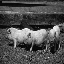

In [12]:
for batch in trainSet.take(1):
    display(array_to_img(batch[0]))

In [13]:
trainSet = trainSet.map(ImageNorm)
trainSet = trainSet.map(lambda x: (Shrink(x),x))

In [14]:
valSet = image_dataset_from_directory(
    directory=trainFolder,
    batch_size=BATCH_SIZE,
    image_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE),
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    color_mode='grayscale',
    seed=random.randrange(RANDRANGE_STOP),
    label_mode=None)

Found 1304 files belonging to 1 classes.
Using 260 files for validation.


In [15]:
valSet = valSet.map(ImageNorm)
valSet = valSet.map(lambda x: (Shrink(x),x))

## Create Model

In [16]:
def SuperResolution(upscaleFactor=UPSCALE_FACTOR, channels=CHANNELS):

    inputs = keras.Input(shape=(None, None, channels))
    x = keras.layers.Conv2D(filters=64, kernel_size=9, activation='relu', kernel_initializer='Orthogonal', padding='same')(inputs)
    x = keras.layers.Conv2D(filters=32, kernel_size=1, activation='relu', kernel_initializer='Orthogonal', padding='same')(x)
    x = keras.layers.Conv2D(filters=(channels * (upscaleFactor ** 2)), kernel_size=5, activation='relu', kernel_initializer='Orthogonal', padding='same')(x)
    outputs = tf.nn.depth_to_space(x, upscaleFactor)

    return keras.Model(inputs, outputs)

In [17]:
def XingyuLong(upscaleFactor=UPSCALE_FACTOR, channels=CHANNELS):
    convArgs = {
        'activation': 'relu',
        'kernel_initializer': 'Orthogonal',
        'padding': 'same'
    }

    inputs = keras.Input(shape=(None, None, channels))
    x = keras.layers.Conv2D(filters=64, kernel_size=5, **convArgs)(inputs)
    x = keras.layers.Conv2D(filters=64, kernel_size=3, **convArgs)(x)
    x = keras.layers.Conv2D(filters=32, kernel_size=3, **convArgs)(x)
    x = keras.layers.Conv2D(filters=(channels * (upscaleFactor ** 2)), kernel_size=3, **convArgs)(x)
    outputs = tf.nn.depth_to_space(x, upscaleFactor)

    return keras.Model(inputs, outputs)

In [18]:
xl = XingyuLong()
xl.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 4)     1156      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0         
Total params: 58,212
Trainable params: 58,212
Non-trainable params: 0
_________________________________________________________

In [19]:
sr = SuperResolution()
sr.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    5248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    2080      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 4)     3204      
_________________________________________________________________
tf.nn.depth_to_space_1 (TFOp (None, None, None, 1)     0         
Total params: 10,532
Trainable params: 10,532
Non-trainable params: 0
_________________________________________________________________


## Train the Model

In [20]:
opt = keras.optimizers.SGD(learning_rate=0.001)
lossFn = keras.losses.MeanSquaredError()

In [17]:
sr.compile(optimizer=opt, loss=lossFn)
sr.fit(trainSet, epochs=EPOCHS, validation_data=valSet, use_multiprocessing=True, verbose=1)

Epoch 1/15
105/105 [==============================] - 11s 77ms/step - loss: 0.1014 - val_loss: 0.0370
Epoch 2/15
105/105 [==============================] - 8s 70ms/step - loss: 0.0350 - val_loss: 0.0330
Epoch 3/15
105/105 [==============================] - 8s 71ms/step - loss: 0.0327 - val_loss: 0.0321
Epoch 4/15
105/105 [==============================] - 8s 70ms/step - loss: 0.0317 - val_loss: 0.0313
Epoch 5/15
105/105 [==============================] - 8s 70ms/step - loss: 0.0309 - val_loss: 0.0305
Epoch 6/15
105/105 [==============================] - 8s 70ms/step - loss: 0.0302 - val_loss: 0.0299
Epoch 7/15
105/105 [==============================] - 8s 70ms/step - loss: 0.0296 - val_loss: 0.0292
Epoch 8/15
105/105 [==============================] - 8s 71ms/step - loss: 0.0288 - val_loss: 0.0287
Epoch 9/15
105/105 [==============================] - 8s 71ms/step - loss: 0.0283 - val_loss: 0.0281
Epoch 10/15
105/105 [==============================] - 8s 71ms/step - loss: 0.0282 - val_l

In [18]:
xl.compile(optimizer=opt, loss=lossFn)
xl.fit(trainSet, epochs=EPOCHS, validation_data=valSet, use_multiprocessing=True, verbose=1)

Epoch 1/15
105/105 [==============================] - 11s 91ms/step - loss: 0.1619 - val_loss: 0.0859
Epoch 2/15
105/105 [==============================] - 9s 82ms/step - loss: 0.0651 - val_loss: 0.0337
Epoch 3/15
105/105 [==============================] - 9s 82ms/step - loss: 0.0311 - val_loss: 0.0273
Epoch 4/15
105/105 [==============================] - 9s 82ms/step - loss: 0.0269 - val_loss: 0.0261
Epoch 5/15
105/105 [==============================] - 9s 83ms/step - loss: 0.0257 - val_loss: 0.0255
Epoch 6/15
105/105 [==============================] - 9s 83ms/step - loss: 0.0252 - val_loss: 0.0250
Epoch 7/15
105/105 [==============================] - 9s 83ms/step - loss: 0.0248 - val_loss: 0.0246
Epoch 8/15
105/105 [==============================] - 9s 82ms/step - loss: 0.0244 - val_loss: 0.0242
Epoch 9/15
105/105 [==============================] - 9s 82ms/step - loss: 0.0238 - val_loss: 0.0238
Epoch 10/15
105/105 [==============================] - 9s 82ms/step - loss: 0.0235 - val_l

## Test the Model

In [19]:
def MagnifyImage(model, lowResImg):
    lowResArr = img_to_array(lowResImg)
    lowResArr = lowResArr.astype('float32')/RESCALE_FACTOR
    input = np.expand_dims(lowResArr, axis=0)
    out = model.predict(input)
    out *= RESCALE_FACTOR
    out = out.reshape((ORIG_IMG_SIZE,ORIG_IMG_SIZE,CHANNELS))
    out = array_to_img(x=out)
    return out

In [20]:
testImgPaths = glob.glob('{}/*.{}'.format(testFolder, IMAGE_EXTENSION))
for idx, testImgPath in enumerate(testImgPaths):
    if idx > 0:
        continue
    img = load_img(testImgPath, color_mode='grayscale')
    hiResImg = img.resize((ORIG_IMG_SIZE,ORIG_IMG_SIZE), resample=PIL.Image.BICUBIC)
    lowResImg = hiResImg.resize((LOW_RES_IMG_SIZE,LOW_RES_IMG_SIZE), resample=PIL.Image.BICUBIC)
    biCubicImg = lowResImg.resize((ORIG_IMG_SIZE,ORIG_IMG_SIZE), resample=PIL.Image.BICUBIC)
    superResImg = MagnifyImage(sr,lowResImg)
    xlImg = MagnifyImage(xl,lowResImg)

NameError: name 'testImgPaths' is not defined

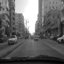

In [1123]:
display(hiResImg)

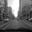

In [1124]:
display(lowResImg)

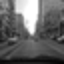

In [1131]:
display(biCubicImg)

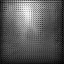

In [1125]:
display(superResImg)

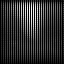

In [1126]:
display(xlImg)